# Post-processing Prompt Collective


In [2]:
import dotenv

dotenv.load_dotenv()

True

In [3]:
from collections import Counter


def unify_responses(rec):
    counter = Counter()
    total_quality = 0
    num_responses = 0
    rating_values = []

    responses = [resp for resp in rec["quality"] if resp["status"] == "submitted"]
    raw_responses = [int(resp["value"]) + 1 for resp in responses]
    for resp in responses:
        quality = int(resp["value"]) + 1
        rating_values.append(quality)
        counter.update([quality])
        total_quality += quality
        num_responses += 1

    average_quality = total_quality / num_responses

    # Compute raw agreement
    most_common_count = counter.most_common(1)[0][1]
    raw_agreement = most_common_count / num_responses

    # Adjust the raw agreement to scale from 0 (no agreement) to 1 (full agreement)
    # The adjustment here is more heuristic and might need more refinement
    agreement = (raw_agreement - 1 / 5) / (1 - 1 / 5)

    return {
        "avg_rating": average_quality,
        "num_responses": num_responses,
        "agreement_ratio": agreement,
        "raw_responses": raw_responses,
    }

In [4]:
from datasets import load_dataset

dataset = load_dataset(
    "DIBT/10k-prompt-collective-argilla-format",
)
dataset

/home/ben/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['prompt', 'quality', 'quality-suggestion', 'quality-suggestion-metadata', 'external_id', 'metadata'],
        num_rows: 10331
    })
})

In [6]:
processed_dataset = dataset.map(unify_responses)

# Inter rater agreement


In [68]:
import numpy as np
from collections import defaultdict
import krippendorff


def prepare_reliability_data(data):
    # Extract unique raters across all units
    unique_raters = set()
    for unit_responses in data:
        for response in unit_responses:
            unique_raters.add(response["user_id"])

    # Map raters to column indices
    rater_to_index = {rater: index for index, rater in enumerate(unique_raters)}

    # Initialize the reliability data matrix with NaNs
    reliability_data = np.full((len(data), len(unique_raters)), np.nan)

    # Populate the matrix with ratings
    for unit_index, unit_responses in enumerate(data):
        for response in unit_responses:
            if response["status"] == "submitted":
                rater_index = rater_to_index[response["user_id"]]
                rating = int(response["value"]) + 1  # Adjust rating as necessary
                reliability_data[unit_index, rater_index] = rating

    return reliability_data.T


df = processed_dataset["train"].to_pandas()
recs = df.loc[df.num_responses >= 2]["quality"]
reliability_data = prepare_reliability_data(recs)
alpha_score = krippendorff.alpha(
    reliability_data=reliability_data, level_of_measurement="ordinal"
)
alpha_score = round(alpha_score, 3)
print(f"krippendorff's alpha: {alpha_score}")

krippendorff's alpha: 0.291


# Rating at Labels


In [54]:
import pandas as pd

df = df.loc[df.num_responses >= 2]

# Create bins for the 'avg_rating' column
bins = pd.cut(df["avg_rating"], bins=5)

label_rating = pd.Series()
# Group the DataFrame by these bins and count the rows in each bin
for bin, avg_rating in df.groupby(bins)["avg_rating"]:
    _df = df.loc[avg_rating.index]
    alpha_score = krippendorff.alpha(
        reliability_data=prepare_reliability_data(_df["quality"]),
        level_of_measurement="ordinal",
    )
    label_rating[bin] = alpha_score

/tmp/ipykernel_2897372/3354853807.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin, avg_rating in df.groupby(bins)["avg_rating"]:


<Axes: title={'center': "Krippendorff's Alpha by Average Rating"}, xlabel="Krippendorff's Alpha", ylabel='Average Rating'>

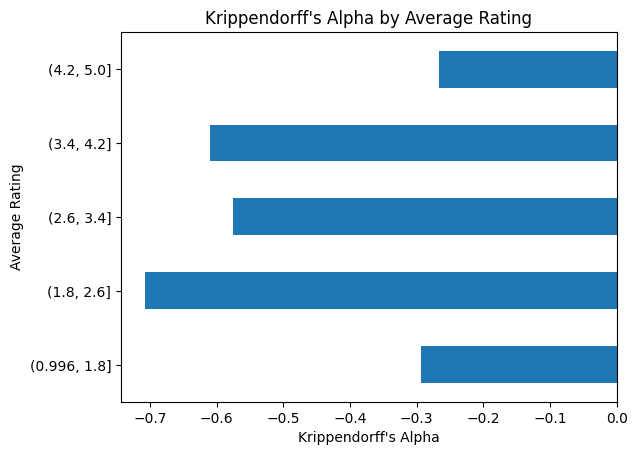

In [55]:
# set axis labels

label_rating.plot(
    kind="barh",
    title="Krippendorff's Alpha by Average Rating",
    ylabel="Average Rating",
    xlabel="Krippendorff's Alpha",
)

# Agreement by user


In [69]:
user_df = df.explode("quality")
user_df["user_id"] = user_df["quality"].apply(lambda x: x.get("user_id"))

## User agreement by average rating


In [70]:
user_df.groupby("user_id")["avg_rating"].describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
0092c596-7348-4760-ad34-6790169a95fa,66.0,3.451010,1.012139,1.0,3.000000,3.500000,4.000000,5.000000
03612c05-3c69-48fc-8bc1-624b436b1906,65.0,3.507253,0.802303,2.0,3.000000,4.000000,4.000000,5.000000
0383bb61-7cc6-4025-943f-411864163fb2,10.0,3.415000,0.828149,2.4,2.750000,3.291667,4.000000,5.000000
0583afc2-2cd8-43b6-a61b-d73dbf2ad9d9,2512.0,3.786663,0.829184,1.0,3.000000,4.000000,4.500000,5.000000
067b1ce7-25f9-4cfd-a9cb-e95eba158c4b,23.0,3.344203,1.338132,1.0,2.125000,4.000000,4.166667,5.000000
...,...,...,...,...,...,...,...,...
fae7553a-e4d2-471d-96cc-78a7a094fb2c,14.0,3.630952,1.033992,2.0,3.125000,4.000000,4.000000,5.000000
fbc67e4b-8b9e-4aa3-9ffe-277c0ee46f65,3.0,3.000000,1.000000,2.0,2.500000,3.000000,3.500000,4.000000
fc6528f0-10ca-461d-82d1-3501fbc1b826,3.0,4.246032,0.647835,3.5,4.035714,4.571429,4.619048,4.666667


In [71]:
bins = pd.cut(user_df["avg_rating"], bins=5)

avg_rating_agreement = pd.Series()
for bin, avg_rating in user_df.groupby(bins)["avg_rating"]:
    _user_df = user_df.loc[avg_rating.index]
    _df_quality = _user_df.groupby(level=0)["quality"].apply(list)
    alpha_score = krippendorff.alpha(
        reliability_data=prepare_reliability_data(_df_quality),
        level_of_measurement="ordinal",
    )
    avg_rating_agreement[bin] = alpha_score

/tmp/ipykernel_2897372/2558243833.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin, avg_rating in user_df.groupby(bins)["avg_rating"]:


<Axes: title={'center': "Krippendorff's Alpha by User Average Rating"}, xlabel="Krippendorff's Alpha", ylabel='User Average Rating'>

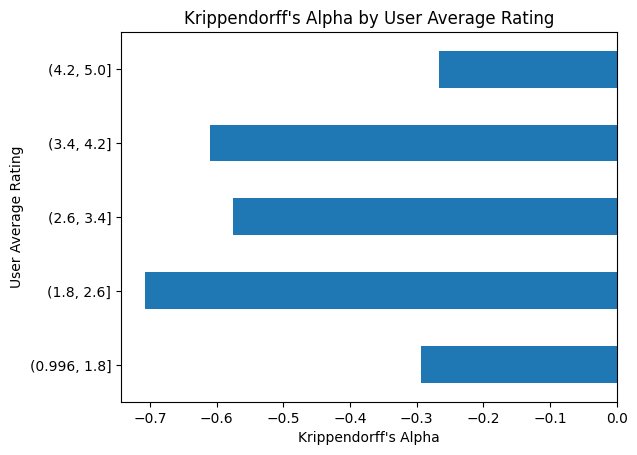

In [72]:
# add title and axis labels
avg_rating_agreement.plot(
    kind="barh",
    title="Krippendorff's Alpha by User Average Rating",
    ylabel="User Average Rating",
    xlabel="Krippendorff's Alpha",
)

## User agreement by agreement ratio


In [73]:
user_df.groupby("user_id")["agreement_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
0092c596-7348-4760-ad34-6790169a95fa,66.0,0.766098,0.311179,0.166667,0.375000,1.000000,1.00000,1.000000
03612c05-3c69-48fc-8bc1-624b436b1906,65.0,0.805540,0.287275,0.166667,0.583333,1.000000,1.00000,1.000000
0383bb61-7cc6-4025-943f-411864163fb2,10.0,0.495833,0.356515,0.166667,0.250000,0.375000,0.84375,1.000000
0583afc2-2cd8-43b6-a61b-d73dbf2ad9d9,2512.0,0.795195,0.291165,0.062500,0.375000,1.000000,1.00000,1.000000
067b1ce7-25f9-4cfd-a9cb-e95eba158c4b,23.0,0.773551,0.294045,0.375000,0.375000,1.000000,1.00000,1.000000
...,...,...,...,...,...,...,...,...
fae7553a-e4d2-471d-96cc-78a7a094fb2c,14.0,0.747024,0.318359,0.166667,0.427083,1.000000,1.00000,1.000000
fbc67e4b-8b9e-4aa3-9ffe-277c0ee46f65,3.0,0.791667,0.360844,0.375000,0.687500,1.000000,1.00000,1.000000
fc6528f0-10ca-461d-82d1-3501fbc1b826,3.0,0.474206,0.104520,0.375000,0.419643,0.464286,0.52381,0.583333


In [74]:
avg_rating_agreement = {}
bins = pd.cut(user_df["agreement_ratio"], bins=5)

for bin_range, grouped_df in user_df.groupby(bins):
    _df_quality = grouped_df.groupby(level=0)["quality"].apply(list)
    _df_quality = _df_quality.loc[_df_quality.apply(len) >= 2]
    if len(_df_quality) >= 10:
        reliability_data = prepare_reliability_data(_df_quality)
        alpha_score = krippendorff.alpha(
            reliability_data=reliability_data, level_of_measurement="ordinal"
        )
        avg_rating_agreement[bin_range] = alpha_score


avg_rating_agreement = pd.Series(avg_rating_agreement)

/tmp/ipykernel_2897372/3295316802.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_range, grouped_df in user_df.groupby(bins):


<Axes: title={'center': "Krippendorff's Alpha by User Agreement Ratio"}, xlabel="Krippendorff's Alpha", ylabel='User Agreement Ratio'>

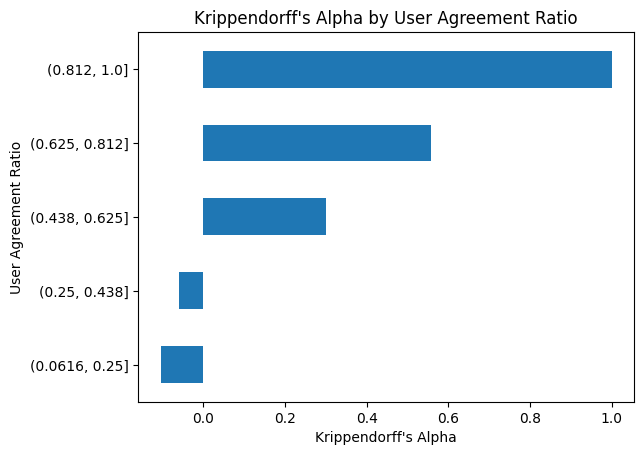

In [75]:
avg_rating_agreement.plot(
    kind="barh",
    title="Krippendorff's Alpha by User Agreement Ratio",
    ylabel="User Agreement Ratio",
    xlabel="Krippendorff's Alpha",
)

# filter on deviation of ratings


<Axes: ylabel='raw_responses'>

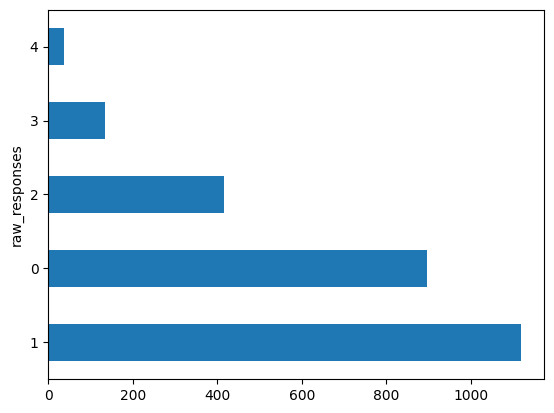

In [76]:
df = df.loc[df.num_responses == 2]
df["raw_responses"].apply(lambda x: max(x) - min(x)).value_counts().plot.barh()

In [77]:
df["diff_max_min"] = df["raw_responses"].apply(lambda x: max(x) - min(x))

In [78]:
bins = pd.cut(df["diff_max_min"], bins=2)

diff_max_min_agreement = pd.Series()
for bin, diff_max_min in df.groupby(bins)["diff_max_min"]:
    _df = df.loc[diff_max_min.index]
    alpha_score = krippendorff.alpha(
        reliability_data=prepare_reliability_data(_df["quality"]),
        level_of_measurement="ordinal",
    )
    diff_max_min_agreement[bin] = alpha_score

/tmp/ipykernel_2897372/482961092.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin, diff_max_min in df.groupby(bins)["diff_max_min"]:


<Axes: title={'center': "Krippendorff's Alpha by Average Rating"}, xlabel="Krippendorff's Alpha", ylabel='Average Rating'>

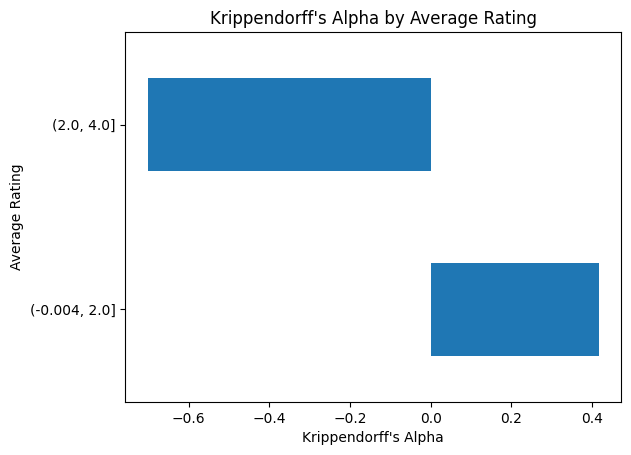

In [79]:
# set axis labels

diff_max_min_agreement.plot(
    kind="barh",
    title="Krippendorff's Alpha by Average Rating",
    ylabel="Average Rating",
    xlabel="Krippendorff's Alpha",
)

In [80]:
prepare_reliability_data(_df["quality"])

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [81]:
bins.value_counts()

diff_max_min
(-0.004, 2.0]    2429
(2.0, 4.0]        171
Name: count, dtype: int64